# 3.5 Factor Analysis on Financial and Economic Time Series

Factor Analysis and Principal Component Analysis on Financial and Economic Time Series

In [1]:
# If you're running this on Colab, make sure to install the following packages using pip.
# On you're own computer, I recommend using conda or mamba.

# !pip install pandas-datareader
# !pip install yfinance

# !conda install pandas-datareader
# !conda install yfinance

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import yfinance as yf
import pandas_datareader as pdr
import sklearn.decomposition
import statsmodels.multivariate.pca

In [3]:
import config
DATA_DIR = config.DATA_DIR

## Downloading macroeconomic and financial data from FRED

In [4]:
fred_series_long_names = {
    'BAMLH0A0HYM2': 'ICE BofA US High Yield Index Option-Adjusted Spread',
    'NASDAQCOM': 'NASDAQ Composite Index',
    'RIFSPPFAAD90NB': '90-Day AA Financial Commercial Paper Interest Rate',
    'TB3MS': '3-Month Treasury Bill Secondary Market Rate',
    'DGS10': 'Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity',
    'VIXCLS': 'CBOE Volatility Index: VIX',
}

In [5]:
fred_series_short_names = {
    'BAMLH0A0HYM2': 'High Yield Index OAS',
    'NASDAQCOM': 'NASDAQ',
    'RIFSPPFAAD90NB': '90-Day AA Fin CP',
    'TB3MS': '3-Month T-Bill',
    'DGS10': '10-Year Treasury',
    'VIXCLS': 'VIX',
}

In [6]:
start_date = pd.to_datetime('1980-01-01') 
end_date = pd.to_datetime('today') 

In [7]:
df = pdr.get_data_fred(fred_series_short_names.keys(), start=start_date, end=end_date)

First, an aside about reading and writing data to disk.

In [8]:
df.to_csv(DATA_DIR / 'fred_panel.csv')

In [9]:
dff = pd.read_csv(DATA_DIR / 'fred_panel.csv')

In [10]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12145 entries, 0 to 12144
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            12145 non-null  object 
 1   BAMLH0A0HYM2    7462 non-null   float64
 2   NASDAQCOM       11490 non-null  float64
 3   RIFSPPFAAD90NB  6599 non-null   float64
 4   TB3MS           547 non-null    float64
 5   DGS10           11396 non-null  float64
 6   VIXCLS          8984 non-null   float64
dtypes: float64(6), object(1)
memory usage: 664.3+ KB


In [11]:
dff = pd.read_csv(DATA_DIR / 'fred_panel.csv', parse_dates=['DATE'])

In [12]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12145 entries, 0 to 12144
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DATE            12145 non-null  datetime64[ns]
 1   BAMLH0A0HYM2    7462 non-null   float64       
 2   NASDAQCOM       11490 non-null  float64       
 3   RIFSPPFAAD90NB  6599 non-null   float64       
 4   TB3MS           547 non-null    float64       
 5   DGS10           11396 non-null  float64       
 6   VIXCLS          8984 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 664.3 KB


In [13]:
dff = dff.set_index('DATE')

In [14]:
df.to_parquet(DATA_DIR / 'fred_panel.parquet')

In [15]:
df = pd.read_parquet(DATA_DIR / 'fred_panel.parquet')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12145 entries, 1980-01-01 to 2025-07-31
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BAMLH0A0HYM2    7462 non-null   float64
 1   NASDAQCOM       11490 non-null  float64
 2   RIFSPPFAAD90NB  6599 non-null   float64
 3   TB3MS           547 non-null    float64
 4   DGS10           11396 non-null  float64
 5   VIXCLS          8984 non-null   float64
dtypes: float64(6)
memory usage: 664.2 KB


In [17]:
df

,BAMLH0A0HYM2,NASDAQCOM,RIFSPPFAAD90NB,TB3MS,DGS10,VIXCLS
DATE,,,,,,
1980-01-01,NaN,NaN,NaN,12.0,NaN,NaN
1980-01-02,NaN,148.17,NaN,NaN,10.50,NaN
1980-01-03,NaN,145.97,NaN,NaN,10.60,NaN
1980-01-04,NaN,148.02,NaN,NaN,10.66,NaN
1980-01-07,NaN,148.62,NaN,NaN,10.63,NaN
...,...,...,...,...,...,...
2025-07-25,2.84,21108.32,4.26,NaN,4.40,14.93
2025-07-28,2.82,21178.58,4.26,NaN,4.42,15.03
2025-07-29,2.86,21098.29,4.32,NaN,4.34,15.98


## Cleaning Data


In [18]:
df = dff.rename(columns=fred_series_short_names)
df

,High Yield Index OAS,NASDAQ,90-Day AA Fin CP,3-Month T-Bill,10-Year Treasury,VIX
DATE,,,,,,
1980-01-01,NaN,NaN,NaN,12.0,NaN,NaN
1980-01-02,NaN,148.17,NaN,NaN,10.50,NaN
1980-01-03,NaN,145.97,NaN,NaN,10.60,NaN
1980-01-04,NaN,148.02,NaN,NaN,10.66,NaN
1980-01-07,NaN,148.62,NaN,NaN,10.63,NaN
...,...,...,...,...,...,...
2025-07-25,2.84,21108.32,4.26,NaN,4.40,14.93
2025-07-28,2.82,21178.58,4.26,NaN,4.42,15.03
2025-07-29,2.86,21098.29,4.32,NaN,4.34,15.98


Balanced panel? Mixed frequencies?

In [19]:
df['3-Month T-Bill'].dropna()

DATE
1980-01-01    12.00
1980-02-01    12.86
1980-03-01    15.20
1980-04-01    13.20
1980-05-01     8.58
              ...  
2025-03-01     4.20
2025-04-01     4.21
2025-05-01     4.25
2025-06-01     4.23
2025-07-01     4.25
Name: 3-Month T-Bill, Length: 547, dtype: float64

Find a daily version of this series. See here: https://fred.stlouisfed.org/categories/22

We will end up using this series: https://fred.stlouisfed.org/series/DTB3

In [20]:
fred_series_short_names = {
    'BAMLH0A0HYM2': 'High Yield Index OAS',
    'NASDAQCOM': 'NASDAQ',
    'RIFSPPFAAD90NB': '90-Day AA Fin CP',
    'DTB3': '3-Month T-Bill',
    'DGS10': '10-Year Treasury',
    'VIXCLS': 'VIX',
}
df = pdr.get_data_fred(fred_series_short_names.keys(), start=start_date, end=end_date)
df = df.rename(columns=fred_series_short_names)

In [21]:
df

,High Yield Index OAS,NASDAQ,90-Day AA Fin CP,3-Month T-Bill,10-Year Treasury,VIX
DATE,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,148.17,NaN,12.17,10.50,NaN
1980-01-03,NaN,145.97,NaN,12.10,10.60,NaN
1980-01-04,NaN,148.02,NaN,12.10,10.66,NaN
1980-01-07,NaN,148.62,NaN,11.86,10.63,NaN
...,...,...,...,...,...,...
2025-07-25,2.84,21108.32,4.26,4.25,4.40,14.93
2025-07-28,2.82,21178.58,4.26,4.24,4.42,15.03
2025-07-29,2.86,21098.29,4.32,4.24,4.34,15.98


In [22]:
df.dropna()

,High Yield Index OAS,NASDAQ,90-Day AA Fin CP,3-Month T-Bill,10-Year Treasury,VIX
DATE,,,,,,
1997-01-02,3.06,1280.70,5.35,5.05,6.54,21.14
1997-01-03,3.09,1310.68,5.35,5.04,6.52,19.13
1997-01-06,3.10,1316.40,5.34,5.05,6.54,19.89
1997-01-07,3.10,1327.73,5.33,5.02,6.57,19.35
1997-01-08,3.07,1320.35,5.31,5.02,6.60,20.24
...,...,...,...,...,...,...
2025-07-24,2.82,21057.96,4.26,4.25,4.43,15.39
2025-07-25,2.84,21108.32,4.26,4.25,4.40,14.93
2025-07-28,2.82,21178.58,4.26,4.24,4.42,15.03


## Transforming and Normalizing the data

What is transformation and normalization? Are these different things?

 - Why would one transform data? What is feature engineering?
 - What is normalization?

What does stationarity mean? See the the following plots. Some of these variable are stationary. Other are not? Why is this a problem?

<Axes: xlabel='DATE'>

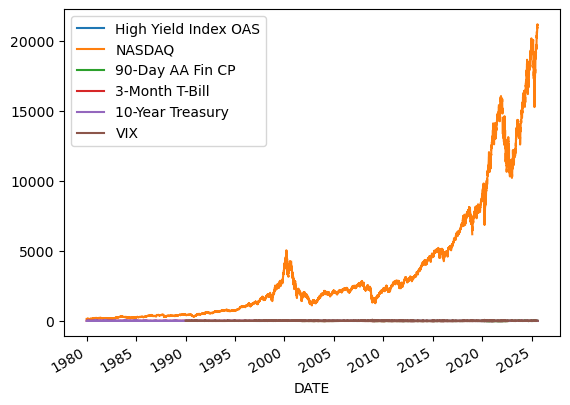

In [23]:
df.plot()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11989 entries, 1980-01-01 to 2025-07-31
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   High Yield Index OAS  7462 non-null   float64
 1   NASDAQ                11490 non-null  float64
 2   90-Day AA Fin CP      6599 non-null   float64
 3   3-Month T-Bill        11396 non-null  float64
 4   10-Year Treasury      11396 non-null  float64
 5   VIX                   8984 non-null   float64
dtypes: float64(6)
memory usage: 655.6 KB


<Axes: xlabel='DATE'>

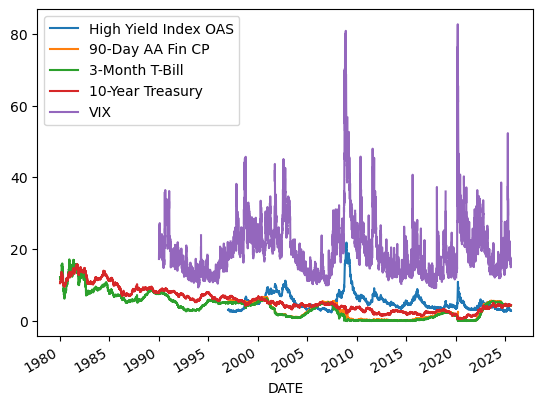

In [25]:
df.drop(columns=['NASDAQ']).plot()

Let's try some transformations like those used in the OFR Financial Stress Index: https://www.financialresearch.gov/financial-stress-index/files/indicators/index.html

In [26]:
dfn = pd.DataFrame().reindex_like(df)
dfn

,High Yield Index OAS,NASDAQ,90-Day AA Fin CP,3-Month T-Bill,10-Year Treasury,VIX
DATE,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-07,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2025-07-25,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-28,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-29,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df['NASDAQ'].rolling(250).mean()

DATE
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-07   NaN
              ..
2025-07-25   NaN
2025-07-28   NaN
2025-07-29   NaN
2025-07-30   NaN
2025-07-31   NaN
Name: NASDAQ, Length: 11989, dtype: float64

In [28]:
df = df.dropna()

In [29]:
df['NASDAQ'].rolling(250).mean()

DATE
1997-01-02            NaN
1997-01-03            NaN
1997-01-06            NaN
1997-01-07            NaN
1997-01-08            NaN
                 ...     
2025-07-24    17079.93916
2025-07-25    17108.53356
2025-07-28    17137.33940
2025-07-29    17166.91224
2025-07-31    17196.51792
Name: NASDAQ, Length: 6579, dtype: float64

In [30]:
# 'High Yield Index OAS': Leave as is
dfn['High Yield Index OAS'] = df['High Yield Index OAS']
dfn['CP - Treasury Spread, 3m'] = df['90-Day AA Fin CP'] - df['3-Month T-Bill']
# 'NASDAQ':  # We're using something different, but still apply rolling mean transformation
dfn['NASDAQ'] = np.log(df['NASDAQ']) - np.log(df['NASDAQ'].rolling(250).mean())
dfn['10-Year Treasury'] = df['10-Year Treasury'] - df['10-Year Treasury'].rolling(250).mean()
# 'VIX': Leave as is
dfn['VIX'] = df['VIX']

In [31]:
dfn = dfn.drop(columns=['90-Day AA Fin CP', '3-Month T-Bill'])
dfn = dfn.dropna()

In [32]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6330 entries, 1998-01-05 to 2025-07-31
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   High Yield Index OAS      6330 non-null   float64
 1   NASDAQ                    6330 non-null   float64
 2   10-Year Treasury          6330 non-null   float64
 3   VIX                       6330 non-null   float64
 4   CP - Treasury Spread, 3m  6330 non-null   float64
dtypes: float64(5)
memory usage: 296.7 KB


We finished with our transformations. Now, let's normalize. First, why is it important?

<Axes: xlabel='DATE'>

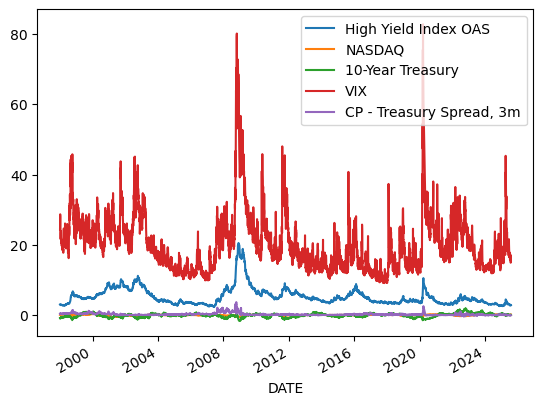

In [33]:
dfn.plot()

Now, normalize each column,
$$
z = \frac{x - \bar x}{\text{std}(x)}
$$

In [34]:
dfn = (dfn - dfn.mean()) / dfn.std()

<Axes: xlabel='DATE'>

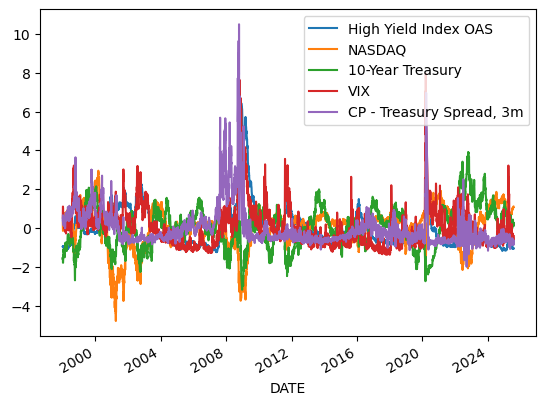

In [35]:
dfn.plot()

In [36]:
def pca(dfn, module='scikitlearn'):
    if module == 'statsmodels':
        _pc1, _loadings, projection, rsquare, _, _, _ = statsmodels.multivariate.pca.pca(dfn,
            ncomp=1, standardize=True, demean=True, normalize=True, gls=False,
            weights=None, method='svd')
        _loadings = _loadings['comp_0']
        loadings = np.std(_pc1) * _loadings
        pc1 = _pc1 / np.std(_pc1)
        pc1 = pc1.rename(columns={'comp_0':'PC1'})['PC1']

    elif module == 'scikitlearn':
        pca = sklearn.decomposition.PCA(n_components=1)
        _pc1 = pd.Series(pca.fit_transform(dfn)[:,0], index=dfn.index, name='PC1')
        _loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
        _loadings = pd.Series(_loadings[:,0], index=dfn.columns)

        loadings = np.std(_pc1) * _loadings
        pc1 = _pc1 / np.std(_pc1)
        pc1.name = 'PC1'
    else:
        raise ValueError



    loadings.name = "loadings"

    return pc1, loadings

def stacked_plot(df, filename=None):
    """
    df=category_contributions
    # category_contributions.sum(axis=1).plot()
    """

    df_pos = df[df >= 0]
    df_neg = df[df < 0]

    alpha = .3
    linewidth = .5

    ax = df_pos.plot.area(alpha=alpha, linewidth=linewidth, legend=False)
    pc1 = df.sum(axis=1)
    pc1.name = 'pc1'
    pc1.plot(color="Black", label='pc1', linewidth=1)


    plt.legend()
    ax.set_prop_cycle(None)
    df_neg.plot.area(alpha=alpha, ax=ax, linewidth=linewidth, legend=False, ylim=(-3,3))
    # recompute the ax.dataLim
    ax.relim()
    # update ax.viewLim using the new dataLim
    ax.autoscale()
    # ax.set_ylabel('Standard Deviations')
    # ax.set_ylim(-3,4)
    # ax.set_ylim(-30,30)

    if not (filename is None):
        filename = Path(filename)
        figure = plt.gcf() # get current figure
        figure.set_size_inches(8, 6)
        plt.savefig(filename, dpi=300)


In [37]:
pc1, loadings = pca(dfn, module='scikitlearn')

<Axes: xlabel='DATE'>

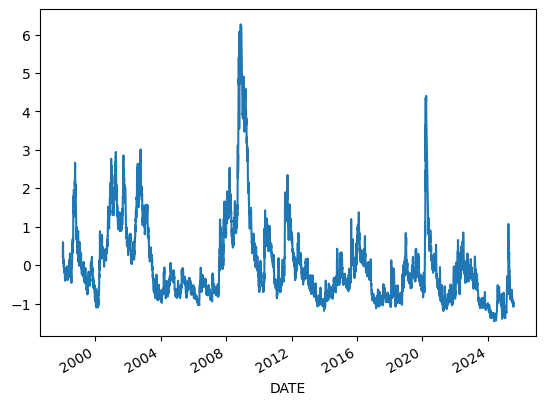

In [38]:
pc1.plot()

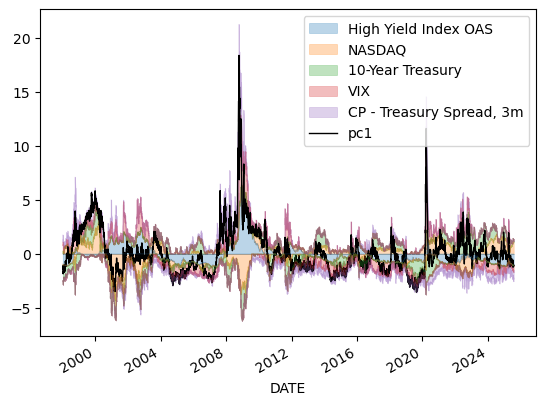

In [39]:
stacked_plot(dfn)

Let's compare solutions from two different packages

In [40]:
def root_mean_squared_error(sa, sb):
    return np.sqrt(np.mean((sa - sb)**2))

pc1_sk, loadings_sk = pca(dfn, module='scikitlearn')
pc1_sm, loadings_sm = pca(dfn, module='statsmodels')
root_mean_squared_error(pc1_sm, pc1_sk)

/opt/homebrew/Caskroom/mambaforge/base/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:4109: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


np.float64(1.4870223507834375e-15)

## Factor Analysis of a Panel of Stock Returns?

In [41]:
# Download sample data for multiple tickers
# Note: yfinance may return different structures depending on version and number of tickers
sample = yf.download("SPY AAPL MSFT", start="2017-01-01", end="2017-04-30", progress=False)


3 Failed downloads:


['MSFT', 'SPY', 'AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


In [42]:
# Let's examine the structure of the downloaded data
print("Sample columns:", sample.columns.tolist() if hasattr(sample, 'columns') else 'No columns attribute')
print("Sample shape:", sample.shape if hasattr(sample, 'shape') else 'No shape attribute')
if hasattr(sample, 'columns') and isinstance(sample.columns, pd.MultiIndex):
    print("Column levels:", sample.columns.levels)
    print("First level values:", sample.columns.levels[0].tolist())


Sample columns: [('Adj Close', 'AAPL'), ('Adj Close', 'MSFT'), ('Adj Close', 'SPY'), ('Close', 'AAPL'), ('Close', 'MSFT'), ('Close', 'SPY'), ('High', 'AAPL'), ('High', 'MSFT'), ('High', 'SPY'), ('Low', 'AAPL'), ('Low', 'MSFT'), ('Low', 'SPY'), ('Open', 'AAPL'), ('Open', 'MSFT'), ('Open', 'SPY'), ('Volume', 'AAPL'), ('Volume', 'MSFT'), ('Volume', 'SPY')]
Sample shape: (0, 18)
Column levels: [['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], ['AAPL', 'MSFT', 'SPY']]
First level values: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']


In [43]:
sample

Empty DataFrame
Columns: [(Adj Close, AAPL), (Adj Close, MSFT), (Adj Close, SPY), (Close, AAPL), (Close, MSFT), (Close, SPY), (High, AAPL), (High, MSFT), (High, SPY), (Low, AAPL), (Low, MSFT), (Low, SPY), (Open, AAPL), (Open, MSFT), (Open, SPY), (Volume, AAPL), (Volume, MSFT), (Volume, SPY)]
Index: []

In [44]:
# When downloading multiple tickers, yfinance returns a DataFrame with MultiIndex columns
# The first level is the data type (e.g., 'Adj Close'), the second level is the ticker
# Display the adjusted close prices for all tickers
adj_close_data = sample['Adj Close'] if 'Adj Close' in sample.columns.get_level_values(0) else sample
adj_close_data

Ticker,AAPL,MSFT,SPY
Date,,,


In [45]:
tickers = [
    'AAPL','ABBV','ABT','ACN','ADP','ADSK','AES','AET','AFL','AMAT','AMGN','AMZN','APA',
    'APHA','APD','APTV','ARE','ASML','ATVI','AXP','BA','BAC','BAX','BDX','BIIB','BK',
    'BKNG','BMY','BRKB','BRK.A','COG','COST','CPB','CRM','CSCO','CVS','DAL','DD','DHR',
    'DIS','DOW','DUK','EMR','EPD','EQT','ESRT','EXPD','FFIV','FLS','FLT','FRT','GE',
    'GILD','GOOGL','GOOG','GS','HAL','HD','HON','IBM','INTC','IP','JNJ','JPM','KEY',
    'KHC','KIM','KO','LLY','LMT','LOW','MCD','MCHP','MDT','MMM','MO','MRK','MSFT',
    'MTD','NEE','NFLX','NKE','NOV','ORCL','OXY','PEP','PFE','PG','RTN','RTX','SBUX',
    'SHW','SLB','SO','SPG','STT','T','TGT','TXN','UNH','UPS','USB','UTX','V','VZ',
    'WMT','XOM',
]

In [46]:
" ".join(tickers)

'AAPL ABBV ABT ACN ADP ADSK AES AET AFL AMAT AMGN AMZN APA APHA APD APTV ARE ASML ATVI AXP BA BAC BAX BDX BIIB BK BKNG BMY BRKB BRK.A COG COST CPB CRM CSCO CVS DAL DD DHR DIS DOW DUK EMR EPD EQT ESRT EXPD FFIV FLS FLT FRT GE GILD GOOGL GOOG GS HAL HD HON IBM INTC IP JNJ JPM KEY KHC KIM KO LLY LMT LOW MCD MCHP MDT MMM MO MRK MSFT MTD NEE NFLX NKE NOV ORCL OXY PEP PFE PG RTN RTX SBUX SHW SLB SO SPG STT T TGT TXN UNH UPS USB UTX V VZ WMT XOM'

In [47]:
data = yf.download(" ".join(tickers), start="1980-01-01", end=pd.to_datetime('today'), progress=False)

Failed to get ticker 'BRKB' reason: Expecting value: line 1 column 1 (char 0)


Failed to get ticker 'FLT' reason: Expecting value: line 1 column 1 (char 0)


Failed to get ticker 'UTX' reason: Expecting value: line 1 column 1 (char 0)


Failed to get ticker 'APHA' reason: Expecting value: line 1 column 1 (char 0)


Failed to get ticker 'RTN' reason: Expecting value: line 1 column 1 (char 0)


Failed to get ticker 'BRK.A' reason: Expecting value: line 1 column 1 (char 0)


Failed to get ticker 'ATVI' reason: Expecting value: line 1 column 1 (char 0)


Failed to get ticker 'COG' reason: Expecting value: line 1 column 1 (char 0)



107 Failed downloads:


['UPS', 'VZ', 'TXN', 'EPD', 'NFLX', 'ABT', 'BMY', 'INTC', 'V', 'BIIB', 'NKE', 'JPM', 'SPG', 'ESRT', 'BK', 'MO', 'MCD', 'COST', 'ARE', 'EQT', 'PFE', 'CVS', 'LLY', 'DIS', 'USB', 'EXPD', 'CSCO', 'SLB', 'AFL', 'BAC', 'MMM', 'DHR', 'APTV', 'HON', 'DD', 'FRT', 'DAL', 'ASML', 'AET', 'GOOG', 'GE', 'WMT', 'T', 'AMZN', 'ORCL', 'ADP', 'MTD', 'APD', 'ABBV', 'PEP', 'OXY', 'AAPL', 'LOW', 'JNJ', 'APA', 'CRM', 'HAL', 'DOW', 'KEY', 'SBUX', 'KO', 'MDT', 'NOV', 'AMAT', 'EMR', 'FFIV', 'BA', 'BDX', 'STT', 'AES', 'SHW', 'UNH', 'GOOGL', 'AMGN', 'NEE', 'PG', 'ACN', 'RTX', 'ADSK', 'AXP', 'MSFT', 'IBM', 'FLS', 'HD', 'GS', 'TGT', 'MCHP', 'MRK', 'DUK', 'XOM', 'IP', 'CPB', 'BKNG', 'BAX', 'LMT', 'GILD', 'KIM', 'KHC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


['BRKB', 'FLT', 'UTX', 'APHA', 'RTN', 'BRK.A', 'ATVI', 'COG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


['SO']: J%ticker%NDecodeError('Expecting value: line 1 column 1 (char 0)')


<Axes: xlabel='Date'>

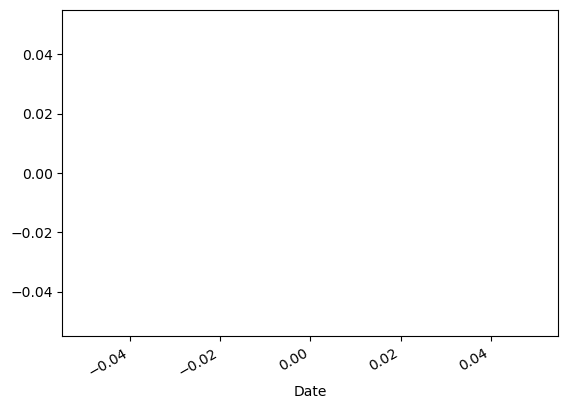

In [48]:
data['Adj Close']['AAPL'].plot()

In [49]:
cols_with_many_nas = [
    "BRK.A",
    "APHA",
    "UTX",
    "RTN",
    "COG",
    "BRKB",
    "ATVI",
    "FLT",
    "DOW",
    "KHC",
    "V",
    "APTV",
    "ABBV",
    "ESRT",
]
df = data['Adj Close']
print(f"Initial shape: {df.shape}")
df = df.drop(columns=cols_with_many_nas, errors='ignore')
print(f"After dropping columns: {df.shape}")
df = df.dropna()
print(f"After first dropna: {df.shape}")
df = df.pct_change()
print(f"After pct_change: {df.shape}")
df = df.dropna()
print(f"Final shape: {df.shape}")

# If DataFrame is empty, use a smaller date range or fewer tickers
if df.empty:
    print("DataFrame is empty! Trying with fewer tickers and recent data...")
    simple_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
    data = yf.download(" ".join(simple_tickers), start="2020-01-01", end=pd.to_datetime('today'), progress=False)
    df = data['Adj Close'].pct_change().dropna()
    print(f"New shape with simple tickers: {df.shape}")


Initial shape: (0, 107)
After dropping columns: (0, 93)
After first dropna: (0, 93)
After pct_change: (0, 93)
Final shape: (0, 93)
DataFrame is empty! Trying with fewer tickers and recent data...


Failed to get ticker 'TSLA' reason: Expecting value: line 1 column 1 (char 0)



5 Failed downloads:


['AAPL', 'AMZN', 'MSFT', 'GOOGL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


['TSLA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


New shape with simple tickers: (0, 5)


In [50]:
df.columns

Index(['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA'], dtype='object', name='Ticker')

<Axes: xlabel='Date'>

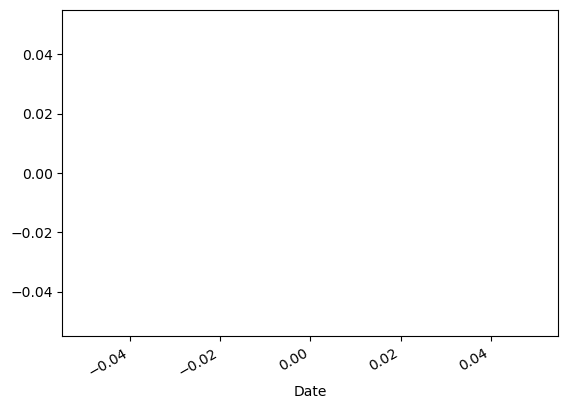

In [51]:
df['AAPL'].plot()

In [52]:
if not df.empty:
    pc1, loadings = pca(df, module='scikitlearn')
    print(f"PCA completed successfully. PC1 shape: {pc1.shape}")
else:
    print("Cannot run PCA on empty DataFrame!")
    pc1 = pd.Series(dtype=float)
    loadings = pd.Series(dtype=float)

Cannot run PCA on empty DataFrame!


In [53]:
if not pc1.empty:
    pc1.plot()
else:
    print("No data to plot for PC1")

No data to plot for PC1


In [54]:
if not pc1.empty:
    pc1.cumsum().plot()
else:
    print("No data to plot for cumulative PC1")

No data to plot for cumulative PC1
